In [12]:
# NBVAL_IGNORE_OUTPUT

import copy
import json
import warnings
from tempfile import NamedTemporaryFile

warnings.filterwarnings("ignore", category=DeprecationWarning)

import cf_xarray as cfxr
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
import xarray as xr
import xesmf as xe
from clisops.core.subset import subset_bbox
from owslib.wfs import WebFeatureService

#  A colormap with grey where the data is missing
cmap = copy.copy(plt.cm.get_cmap("viridis"))
cmap.set_bad("lightgray")

In [13]:
# NBVAL_IGNORE_OUTPUT

# The input test data is hosted on the Ouranos THREDDS
url = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/birdhouse/testdata/xclim/cmip6/sic_SImon_CCCma-CanESM5_ssp245_r13i1p2f1_2020.nc"
ds_in = xr.open_dataset(url)
ds_in

<xarray.Dataset> Size: 14MB
Dimensions:             (time: 12, bnds: 2, j: 291, i: 360, vertices: 4)
Coordinates:
  * time                (time) object 96B 2020-01-16 12:00:00 ... 2020-12-16 ...
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 285 286 287 288 289 290
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    type                |S64 64B ...
    latitude            (j, i) float64 838kB ...
    longitude           (j, i) float64 838kB ...
Dimensions without coordinates: bnds, vertices
Data variables:
    time_bnds           (time, bnds) object 192B ...
    vertices_latitude   (j, i, vertices) float64 3MB ...
    vertices_longitude  (j, i, vertices) float64 3MB ...
    siconc              (time, j, i) float32 5MB ...
    areacello           (j, i) float32 419kB ...
Attributes: (12/56)
    CCCma_model_hash:                fc4bb7db954c862d023b546e19aec6c588bc0552
    CCCma_parent_runid:              p2-his13
    CCCma_pycmor_hash:               26c970628162d607fffd14254956ebc6dd3b6f49
    CCCma_runid:                     p2-s4513
    Conventions:                     CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:       2015:01:01:00
    ...                              ...
    license:                         CMIP6 model data produced by The Governm...
    cmor_version:                    3.5.0
    tracking_id:                     hdl:21.14100/9e4f804b-c161-44fa-acd1-c2e...
    DODS.strlen:                     64
    DODS.dimName:                    maxStrlen64
    DODS_EXTRA.Unlimited_Dimension:  time

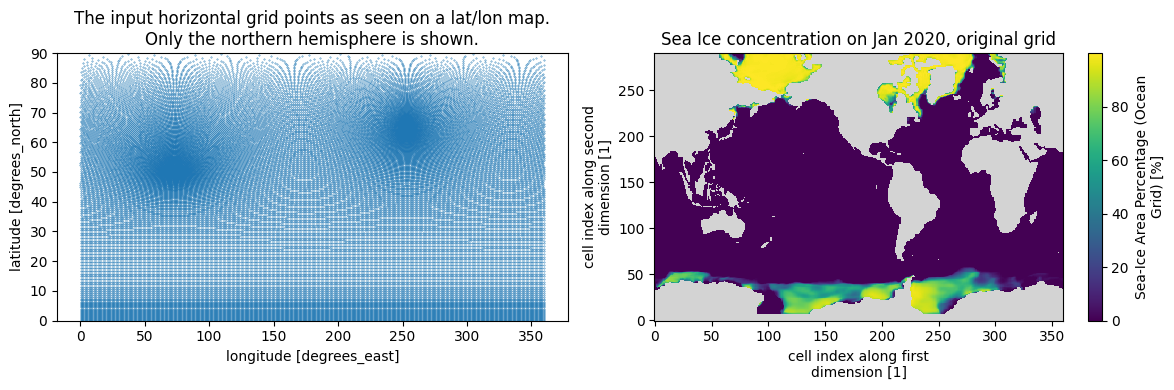

In [14]:
# Let's look at the grid shape itself and the data for one time step
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))

axs[0].scatter(x=ds_in.longitude.values, y=ds_in.latitude.values, s=0.1)
axs[0].set_title(
    "The input horizontal grid points as seen on a lat/lon map.\nOnly the northern hemisphere is shown."
)
axs[0].set_ylim(0, 90)
axs[0].set_ylabel(f"latitude [{ds_in.latitude.units}]")
axs[0].set_xlabel(f"longitude [{ds_in.longitude.units}]")
ds_in.siconc.isel(time=0).plot(ax=axs[1], cmap=cmap)
axs[1].set_title("Sea Ice concentration on Jan 2020, original grid")
fig.tight_layout()

In [15]:
# NBVAL_IGNORE_OUTPUT

url_obs = "https://pavics.ouranos.ca/twitcher/ows/proxy/thredds/dodsC/datasets/gridded_obs/nrcan_v2.ncml"

# For this example, we're not interested in the observation data, only its underlying grid, so we'll select a single time step.
ds_obs = xr.open_dataset(url_obs).sel(time="1993-05-20").drop("time")

# Subset over the Hudson Bay and the Labrador Sea for the example
bbox = dict(lon_bnds=[-99.5, -41.92], lat_bnds=[50.35, 67.61])
ds_tgt = subset_bbox(ds_obs, **bbox)
ds_tgt

<xarray.Dataset> Size: 1MB
Dimensions:  (lat: 207, lon: 570)
Coordinates:
  * lat      (lat) float32 828B 67.54 67.46 67.38 67.29 ... 50.54 50.46 50.38
  * lon      (lon) float32 2kB -99.46 -99.38 -99.29 ... -52.21 -52.13 -52.04
Data variables:
    tasmin   (lat, lon) float32 472kB ...
    tasmax   (lat, lon) float32 472kB ...
    pr       (lat, lon) float32 472kB ...
Attributes: (12/15)
    Conventions:          CF-1.5
    title:                NRCAN ANUSPLIN daily gridded dataset : version 2
    history:              Fri Jan 25 14:11:15 2019 : Convert from original fo...
    institute_id:         NRCAN
    frequency:            day
    abstract:             Gridded daily observational dataset produced by Nat...
    ...                   ...
    dataset_id:           NRCAN_anusplin_daily_v2
    version:              2.0
    license_type:         permissive
    license:              https://open.canada.ca/en/open-government-licence-c...
    attribution:          The authors provide this data under the Environment...
    citation:             Natural Resources Canada ANUSPLIN interpolated hist...

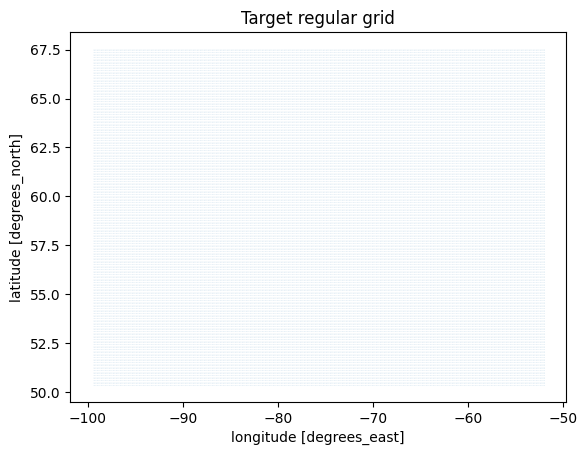

In [16]:
# NBVAL_IGNORE_OUTPUT

ds_tgt.cf.plot.scatter(x="longitude", y="latitude", s=0.1)
plt.title("Target regular grid");

In [17]:
# NBVAL_IGNORE_OUTPUT

ds_in.cf.describe()

Coordinates:
             CF Axes: * X: ['i']
                      * Y: ['j']
                      * T: ['time']
                        Z: n/a

      CF Coordinates:   longitude: ['longitude']
                        latitude: ['latitude']
                      * time: ['time']
                        vertical: n/a

       Cell Measures:   area, volume: n/a

      Standard Names:   area_type: ['type']
                        latitude: ['latitude']
                        longitude: ['longitude']
                      * time: ['time']

              Bounds:   n/a

       Grid Mappings:   n/a

Data Variables:
       Cell Measures:   area: ['areacello']
                        volume: n/a

      Standard Names:   cell_area: ['areacello']
                        sea_ice_area_fraction: ['siconc']

              Bounds:   T: ['time_bnds']
                        latitude: ['vertices_latitude']
                        longitude: ['vertices_longitude']
                        time: ['time_b

In [8]:
# Get the bounds variable and convert them to "vertices" format
# Order=none, means that we do not know if the bounds are listed clockwise or counterclockwise, so we ask cf_xarray to try both.
lat_corners = cfxr.bounds_to_vertices(ds_in.vertices_latitude, "vertices", order=None)
lon_corners = cfxr.bounds_to_vertices(ds_in.vertices_longitude, "vertices", order=None)
ds_in_crns = ds_in.assign(lon_b=lon_corners, lat_b=lat_corners)

In [20]:
ds_in_crns

<xarray.Dataset> Size: 16MB
Dimensions:             (time: 12, bnds: 2, j: 291, i: 360, vertices: 4,
                         j_vertices: 292, i_vertices: 361)
Coordinates:
  * time                (time) object 96B 2020-01-16 12:00:00 ... 2020-12-16 ...
  * j                   (j) int32 1kB 0 1 2 3 4 5 6 ... 285 286 287 288 289 290
  * i                   (i) int32 1kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
    type                |S64 64B b'sea_ice'
    latitude            (j, i) float64 838kB -78.39 -78.39 ... 50.23 50.01
    longitude           (j, i) float64 838kB 73.5 74.5 75.5 ... 72.96 72.99
Dimensions without coordinates: bnds, vertices, j_vertices, i_vertices
Data variables:
    time_bnds           (time, bnds) object 192B ...
    vertices_latitude   (j, i, vertices) float64 3MB -78.29 -78.49 ... 50.11
    vertices_longitude  (j, i, vertices) float64 3MB 74.0 74.0 ... 72.95 73.0
    siconc              (time, j, i) float32 5MB nan nan nan nan ... nan nan nan
    areacello           (j, i) float32 419kB ...
    lon_b               (j_vertices, i_vertices) float64 843kB 74.0 ... 72.95
    lat_b               (j_vertices, i_vertices) float64 843kB -78.29 ... 50.11
Attributes: (12/56)
    CCCma_model_hash:                fc4bb7db954c862d023b546e19aec6c588bc0552
    CCCma_parent_runid:              p2-his13
    CCCma_pycmor_hash:               26c970628162d607fffd14254956ebc6dd3b6f49
    CCCma_runid:                     p2-s4513
    Conventions:                     CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:       2015:01:01:00
    ...                              ...
    license:                         CMIP6 model data produced by The Governm...
    cmor_version:                    3.5.0
    tracking_id:                     hdl:21.14100/9e4f804b-c161-44fa-acd1-c2e...
    DODS.strlen:                     64
    DODS.dimName:                    maxStrlen64
    DODS_EXTRA.Unlimited_Dimension:  time

In [10]:
ds_tgt

<xarray.Dataset> Size: 1MB
Dimensions:  (lat: 207, lon: 570)
Coordinates:
  * lat      (lat) float32 828B 67.54 67.46 67.38 67.29 ... 50.54 50.46 50.38
  * lon      (lon) float32 2kB -99.46 -99.38 -99.29 ... -52.21 -52.13 -52.04
Data variables:
    tasmin   (lat, lon) float32 472kB ...
    tasmax   (lat, lon) float32 472kB ...
    pr       (lat, lon) float32 472kB ...
Attributes: (12/15)
    Conventions:          CF-1.5
    title:                NRCAN ANUSPLIN daily gridded dataset : version 2
    history:              Fri Jan 25 14:11:15 2019 : Convert from original fo...
    institute_id:         NRCAN
    frequency:            day
    abstract:             Gridded daily observational dataset produced by Nat...
    ...                   ...
    dataset_id:           NRCAN_anusplin_daily_v2
    version:              2.0
    license_type:         permissive
    license:              https://open.canada.ca/en/open-government-licence-c...
    attribution:          The authors provide this data under the Environment...
    citation:             Natural Resources Canada ANUSPLIN interpolated hist...

In [9]:
%%time

conservative_regridder = NamedTemporaryFile(delete=False, suffix=".nc")

reg_cons = xe.Regridder(
    ds_in_crns, ds_tgt, "conservative", filename=conservative_regridder.name
)
print(reg_cons)

# Regrid as before
sic_cons = reg_cons(ds_in_crns.siconc)

xESMF Regridder 
Regridding algorithm:       conservative 
Weight filename:            /tmp/tmp51fdhkvd.nc 
Reuse pre-computed weights? False 
Input grid shape:           (291, 360) 
Output grid shape:          (207, 570) 
Periodic in longitude?      False
CPU times: user 4.72 s, sys: 232 ms, total: 4.95 s
Wall time: 8.35 s
